In [2]:
#%% Libraries import
# import HiDeNN library
import sys  
sys.path.insert(1, '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d')

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions
from Bin.PDE_Library import Strain, Stress,VonMises_plain_strain
# Import Training funcitons
from Bin.Training import Training_2D_FEM
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [3]:
Default_config_file = 'Configuration/config_2D.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in Configuration/config_2D.toml


In [4]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"
eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = [2.0, 1.0, 0.5, 0.25, 0.125]
config["solver"]["FrozenMesh"] = True
optimizers = ["adam","lbfgs"]

error_u = numpy.zeros((len(element_size),len(optimizers)))
error_v = numpy.zeros((len(element_size),len(optimizers)))
error_stress = numpy.zeros((len(element_size),len(optimizers)))
error_stress_max = numpy.zeros((len(element_size),len(optimizers)))

for e in range(len(element_size)):
    config["interpolation"]["MaxElemSize2D"] = element_size[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        if config["interpolation"]["dimension"] == 1:
            Mat = pre.Material(             flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["E"],            # Young Modulus
                                            coef2     = config["geometry"]["A"]             # Section area of the 1D bar
                                )
        elif config["interpolation"]["dimension"] == 2:
            try:
                Mat = pre.Material(         flag_lame = False,                              # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["E"],            # Young Modulus
                                            coef2     = config["material"]["nu"]            # Poisson's ratio
                                )
            except:
                Mat = pre.Material(         flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                            coef1     = config["material"]["lmbda"],        # First Lame's coef
                                            coef2     = config["material"]["mu"]            # Second Lame's coef
                                )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4658e+00
epoch 50 loss = 5.3127e+00
epoch 100 loss = 4.3188e+00
epoch 150 loss = 3.5166e+00
epoch 200 loss = 2.8792e+00
epoch 250 loss = 2.3808e+00
epoch 300 loss = 1.9971e+00
epoch 350 loss = 1.7063e+00
epoch 400 loss = 1.489e+00
epoch 450 loss = 1.3289e+00
epoch 500 loss = 1.2126e+00
epoch 550 loss = 1.1291e+00
epoch 600 loss = 1.0698e+00
epoch 650 loss = 1.0282e+00
epoch 700 loss = 9.994e-01
epoch 750 loss = 9.7963e-01
epoch 800 loss = 9.6623e-01
epoch 850 loss = 9.5726e-01
epoch 900 loss = 9.5134e-01
epoch 9

In [5]:
print("Adam")
print("u = ", error_u[:,0])
print("v = ", error_v[:,0])
print("s = ", error_stress[:,0])
print("s max = ", error_stress_max[:,0])
print()
print("LBFGS")
print("u = ", error_u[:,1])
print("v = ", error_v[:,1])
print("s = ", error_stress[:,1])
print("s max = ", error_stress_max[:,1])

Adam
u =  [0.18800445 0.10261439 0.03856681 0.0224262  0.08483452]
v =  [0.02598276 0.01087553 0.00346088 0.00123791 0.00222648]
s =  [0.22969368 0.147227   0.08268468 0.04345163 0.02758764]
s max =  [0.6559485  0.77596868 0.93877005 0.95501836 1.00001859]

LBFGS
u =  [0.18588991 0.10080447 0.03665088 0.00976974 0.00210923]
v =  [0.02586959 0.01065384 0.00328925 0.00084002 0.00016468]
s =  [0.22989806 0.14733525 0.08272102 0.0431467  0.0219762 ]
s max =  [0.65594826 0.77632042 0.93821341 0.95493981 0.99331903]


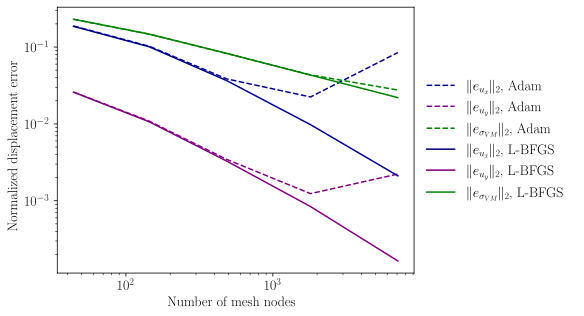

In [6]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_u[:,0],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_v[:,0],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_stress[:,0],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", Adam")

plt.plot(mesh_resolution, error_u[:,1],'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_v[:,1],'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_stress[:,1],'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS")


ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()


In [7]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

# eval_coord_file = "../2D_example/eval_coordinates.npy"
# num_displ_file = "../2D_example/num_solution/num_displacement.npy"
# num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"
eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"

eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizers = ["adam","lbfgs"]
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size

r_adapt_error_u = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_v = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress_max = numpy.zeros((len(refinment),len(optimizers)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # Young Modulus
                                        coef2     = config["material"]["mu"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        # Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
        coordinates_all = torch.ones_like(Model_FEM.coordinates_all)
        coordinates_all[Model_FEM.coord_free] = Model_FEM.coordinates['free']
        coordinates_all[~Model_FEM.coord_free] = Model_FEM.coordinates['imposed']
        Nodes = torch.hstack([torch.linspace(1,coordinates_all.shape[0],coordinates_all.shape[0], dtype = coordinates_all.dtype, device = coordinates_all.device)[:,None],
                                coordinates_all])
        Nodes = torch.hstack([Nodes,torch.zeros(Nodes.shape[0],1, dtype = Nodes.dtype, device = Nodes.device)])
        Model_FEM.mesh.Nodes = Nodes.detach().cpu().numpy()
        Model_FEM.mesh.Connectivity = Model_FEM.connectivity
        Model_FEM.mesh.ExportMeshVtk(flag_update = True)

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        r_adapt_error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        r_adapt_error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        r_adapt_error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        r_adapt_error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4619e+00
epoch 50 loss = 5.1704e+00
epoch 100 loss = 4.1221e+00
epoch 150 loss = 3.3191e+00
epoch 200 loss = 2.7076e+00
epoch 250 loss = 2.2450e+00
epoch 300 loss = 1.8976e+00
epoch 350 loss = 1.6384e+00
epoch 400 loss = 1.4463e+00
epoch 450 loss = 1.3048e+00
epoch 500 loss = 1.2010e+00
epoch 550 loss = 1.1252e+00
epoch 600 loss = 1.0702e+00
epoch 650 loss = 1.0303e+00
epoch 700 loss = 1.0018e+00
epoch 750 loss = 9.8135e-01
epoch 800 loss = 9.6690e-01
epoch 850 loss = 9.5674e-01
epoch 900 loss = 9.4963e-01
epoch

In [8]:
print("Adam")
print("u = ", r_adapt_error_u[:,0])
print("v = ", r_adapt_error_v[:,0])
print("s = ", r_adapt_error_stress[:,0])
print("s max = ", r_adapt_error_stress_max[:,0])
print()
print("LBFGS")
print("u = ", r_adapt_error_u[:,1])
print("v = ", r_adapt_error_v[:,1])
print("s = ", r_adapt_error_stress[:,1])
print("s max = ", r_adapt_error_stress_max[:,1])


error_u = numpy.zeros((5,len(optimizers)))
error_v = numpy.zeros((5,len(optimizers)))
error_stress = numpy.zeros((5,len(optimizers)))
error_stress_max = numpy.zeros((5,len(optimizers)))

# Adam
error_u[:,0] =          [0.18775588, 0.10230352, 0.04060538, 0.02128754, 0.07499295]
error_v[:,0] =          [0.02596945, 0.01084645, 0.00363882, 0.00121237, 0.00198047]
error_stress[:,0] =     [0.22971469, 0.14722798, 0.0826846,  0.0434168,  0.02648678]
error_stress_max[:,0] = [0.65595128, 0.77592806, 0.93797397, 0.95504362, 0.99851   ]

# LBFGS
error_u[:,1] =          [0.18588991, 0.10080447, 0.03665099, 0.00976881, 0.00178625]
error_v[:,1] =          [0.02586959, 0.01065384, 0.00328927, 0.00083952, 0.00015972]
error_stress[:,1] =     [0.22989806, 0.14733525, 0.08272104, 0.04314679, 0.02197644]
error_stress_max[:,1] = [0.65594826, 0.77632042, 0.93821257, 0.95494309, 0.99339041]

Adam
u =  [0.19393273 0.07558538 0.02456685 0.00996755 0.00898342]
v =  [0.02566366 0.00814481 0.00239728 0.00075528 0.00048327]
s =  [0.2193788  0.11355883 0.06778975 0.03947853 0.02187519]
s max =  [0.68676941 0.87718206 1.01375719 0.99676224 1.01566631]

LBFGS
u =  [0.19644873 0.07497219 0.0227529  0.0066333  0.00088792]
v =  [0.02515028 0.00827875 0.00237551 0.00061176 0.00012711]
s =  [0.21959154 0.11366621 0.06445931 0.03553715 0.0198824 ]
s max =  [0.68675655 0.87800155 0.95892097 0.99186651 0.99645209]


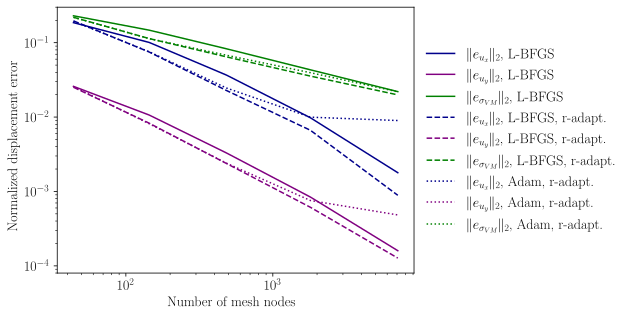

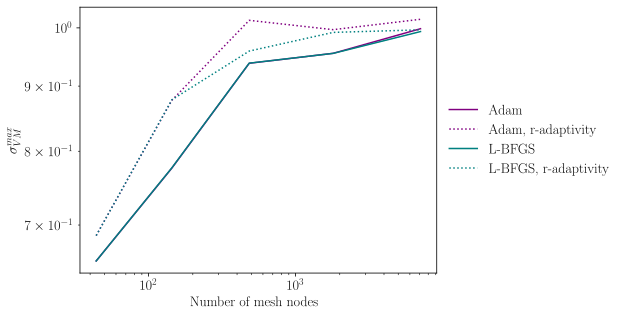

In [9]:
# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_u[:,1],'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_v[:,1],'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_stress[:,1],'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS")

plt.plot(mesh_resolution, r_adapt_error_u[:,1],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_v[:,1],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_stress[:,1],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS, r-adapt.")

plt.plot(mesh_resolution, r_adapt_error_u[:,0],':', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", Adam, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_v[:,0],':', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", Adam, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_stress[:,0],':', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", Adam, r-adapt.")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00008, 0.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot maximal stress

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_stress_max[:,0],'-', color = "purple", label = "Adam")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,0],':', color = "purple", label = "Adam, r-adaptivity")
plt.plot(mesh_resolution, error_stress_max[:,1],'-', color = "teal", label = "L-BFGS")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,1],':', color = "teal", label =  "L-BFGS, r-adaptivity")

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel(r'$\sigma^{max}_{VM}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()


In [10]:

# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

# eval_coord_file = "../2D_example/eval_coordinates.npy"
# num_displ_file = "../2D_example/num_solution/num_displacement.npy"
# num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"

eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement.npy"
num_VM_stress_file = "GroundTruth/num_VM_stress.npy"

eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizer = "lbfgs"
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size
config["training"]["optimizer"] = optimizer
config["training"]["h_adapt_MaxGeneration"] = 2

rh_adapt_error_u = numpy.zeros((len(refinment)))
rh_adapt_error_v = numpy.zeros((len(refinment)))
rh_adapt_error_stress = numpy.zeros((len(refinment)))
rh_adapt_error_stress_max = numpy.zeros((len(refinment)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]

    Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                    coef1     = config["material"]["lmbda"],        # Young Modulus
                                    coef2     = config["material"]["mu"]        # Poisson's ratio
                        )

    MaxElemSize = pre.ElementSize(
                                    dimension     = config["interpolation"]["dimension"],
                                    L             = config["geometry"]["L"],
                                    order         = config["interpolation"]["order"],
                                    np            = config["interpolation"]["np"],
                                    MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                )
    Excluded = []
    Mesh_object = pre.Mesh( 
                                    config["geometry"]["Name"],                 # Create the mesh object
                                    MaxElemSize, 
                                    config["interpolation"]["order"], 
                                    config["interpolation"]["dimension"]
                            )

    Mesh_object.AddBorders(config["Borders"]["Borders"])
    Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                    config["geometry"]["Volume_element"],
                                    Excluded,
                                    config["DirichletDictionryList"]
                        )                   

    Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
    Mesh_object.ReadMesh()                                                      # Parse the .msh file
    Mesh_object.ExportMeshVtk()

    if int(Mesh_object.dim) != int(Mesh_object.dimension):
        raise ValueError("The dimension of the provided geometry does not match the job dimension")

    Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

    Model_FEM.Freeze_Mesh()
    Model_FEM.UnFreeze_FEM()

    if not config["solver"]["FrozenMesh"]:
        Model_FEM.UnFreeze_Mesh() 

    Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

    Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                    Max_epochs = config["training"]["n_epochs"], 
                                    learning_rate = config["training"]["learning_rate"])
    Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
    
    # evaluation 
    Model_FEM.eval()

    # Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
    coordinates_all = torch.ones_like(Model_FEM.coordinates_all)
    coordinates_all[Model_FEM.coord_free] = Model_FEM.coordinates['free']
    coordinates_all[~Model_FEM.coord_free] = Model_FEM.coordinates['imposed']
    Nodes = torch.hstack([torch.linspace(1,coordinates_all.shape[0],coordinates_all.shape[0], dtype = coordinates_all.dtype, device = coordinates_all.device)[:,None],
                            coordinates_all])
    Nodes = torch.hstack([Nodes,torch.zeros(Nodes.shape[0],1, dtype = Nodes.dtype, device = Nodes.device)])
    Model_FEM.mesh.Nodes = Nodes.detach().cpu().numpy()
    Model_FEM.mesh.Connectivity = Model_FEM.connectivity
    Model_FEM.mesh.ExportMeshVtk(flag_update = True)

    elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
    u = Model_FEM(eval_coord, elem_IDs)
    eps =  Strain(u,eval_coord)
    sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
    sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

    rh_adapt_error_u[e] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
    rh_adapt_error_v[e] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
    rh_adapt_error_stress[e] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
    rh_adapt_error_stress_max[e] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           88

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 3 loss = 9.3266e-01
epoch 4 loss = 9.3022e-01
epoch 5 loss = 9.3013e-01
epoch 6 loss = 9.2282e-01
epoch 7 loss = 9.2010e-01
epoch 8 loss = 9.1916e-01
epoch 9 loss = 9.1817e-01
epoch 10 loss = 9.1780e-01
epoch 11 loss = 9.1772e-01
epoch 12 loss = 9.1767e-01
epoch 13 loss = 9.1766e-01
epoch 14 loss = 9.1766e-01
epoch 15 loss = 9.1766e-01
epoch 16 loss = 9.1766e-01
epoch 17 loss = 9.1766e-01
epoch 18 loss = 9.1766e-01
*************** END FIRST PHASE ***************

* Training time: 0.686204910278320

In [11]:
print("LBFGS")
print("u = ", rh_adapt_error_u[:])
print("v = ", rh_adapt_error_v[:])
print("s = ", rh_adapt_error_stress[:])
print("s max = ", rh_adapt_error_stress_max[:])


LBFGS
u =  [0.16129555 0.05830956 0.02171129 0.00462844 0.00105947]
v =  [0.02091562 0.00612387 0.00211784 0.00049789 0.00011466]
s =  [0.20230262 0.09546001 0.0635462  0.03225828 0.02035895]
s max =  [0.8557009  0.96096158 1.0040101  1.0120337  0.97600854]


(5,)


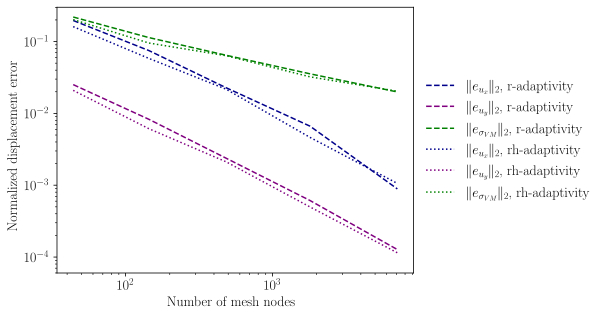

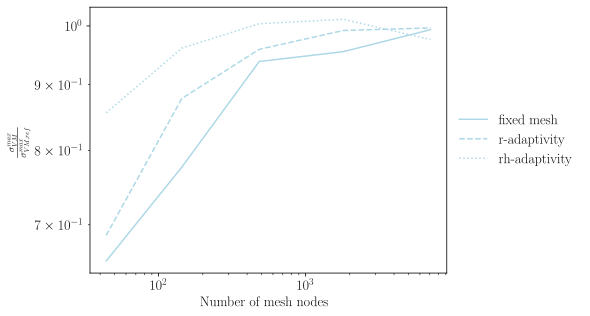

In [15]:
# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

print(rh_adapt_error_u.shape)

plt.plot(mesh_resolution, r_adapt_error_u[:,1],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_v[:,1],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_stress[:,1],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", r-adaptivity")

plt.plot(mesh_resolution, rh_adapt_error_u,':', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_v,':', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress,':', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", rh-adaptivity")


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00006, 0.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot maximal stress

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_stress_max[:,1],'-', color = "lightblue", label = "fixed mesh")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,1],'--', color = "lightblue", label =  "r-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress_max,':', color = "lightblue", label =  "rh-adaptivity")

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
# plt.ylabel(r'$\sigma^{max}_{VM}$')
plt.ylabel(r'$\frac{\sigma_{VM}^{max}}{\sigma_{VM, ref}^{max}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()
